In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image

# ===============================
# 1. Train Skin Cancer Model
# ===============================

In [2]:
def train_skin_cancer():
    train_dir = "skin_cancer_subset_700"
    img_size = (128,128)
    batch_size = 16

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_flow = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode="binary", subset="training"
    )
    val_flow = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode="binary", subset="validation"
    )

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(train_flow, validation_data=val_flow, epochs=5, verbose=1)

    return model, list(train_flow.class_indices.keys())

# ===============================
# 2. Plot Training History Function
# ===============================

In [3]:
def plot_training_history(history, title="Model Accuracy/Loss"):
    plt.figure(figsize=(12,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


# ===============================
# 3. Train Pneumonia Model
# ===============================

In [4]:
def train_pneumonia():
    train_dir = "pneumonia_subset_700"
    img_size = (128,128)
    batch_size = 16

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_flow = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode="binary", subset="training"
    )
    val_flow = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode="binary", subset="validation",
        shuffle=False   # Important for ROC curve
    )

    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(train_flow, validation_data=val_flow, epochs=5, verbose=1)

    # Plot training history
    plot_training_history(history, title="Pneumonia Model")

    # ROC Curve
    val_labels = val_flow.classes
    val_preds = model.predict(val_flow, verbose=0).ravel()
    fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
    auc_score = roc_auc_score(val_labels, val_preds)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Pneumonia ROC Curve")
    plt.legend()
    plt.show()

    return model, list(train_flow.class_indices.keys())



# ===============================
# 4. Safe Prediction Function
# ===============================

In [ ]:
def predict_image_safe(model, class_names):
    img_path = input("\n👉 Enter image path for prediction: ")

    if not os.path.exists(img_path):
        print(" File not found!")
        return

    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((128,128))
    except Exception as e:
        print(" Cannot open this image. It may be corrupted.")
        return

    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    predicted_class = class_names[int(round(prediction))]

    if predicted_class.lower() in ["benign","normal"]:
        print(f"\n Prediction: Healthy ({predicted_class})")
    else:
        print(f"\n Prediction: Disease ({predicted_class})")



# ===============================
# 5. Main Menu
# ===============================

In [ ]:

def main_menu():
    skin_model, skin_classes = train_skin_cancer()
    pneu_model, pneu_classes = train_pneumonia()

    while True:
        print("\n====== MEDICAL PREDICTION MENU ======")
        print("1. Skin Cancer Detection")
        print("2. Pneumonia Detection")
        print("3. Exit")
        choice = input(" Enter choice (1-3): ")

        if choice == "1":
            predict_image_safe(skin_model, skin_classes)
        elif choice == "2":
            predict_image_safe(pneu_model, pneu_classes)
        elif choice == "3":
            print(" Exiting... Stay Healthy!")
            break
        else:
            print(" Invalid choice, try again!")

        again = input("\nDo you want to predict again? (y/n): ").lower()
        if again != "y":
            print(" Program Ended. Goodbye!")
            break

# ===============================
# Run Program
# ===============================

Found 560 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


c:\Users\ABC\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4911 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4768 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4750 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4964 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4714 - loss: 0.6959 - val_accuracy: 0.4929 - val_loss: 0.6941
Found 357 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


c:\Users\ABC\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 650ms/step - accuracy: 0.4986 - loss: 0.7186 - val_accuracy: 0.5568 - val_loss: 0.6910
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.5154 - loss: 0.6922 - val_accuracy: 0.5227 - val_loss: 0.6893
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - accuracy: 0.5238 - loss: 0.6876 - val_accuracy: 0.4773 - val_loss: 0.7012
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 670ms/step - accuracy: 0.5182 - loss: 0.6849 - val_accuracy: 0.5227 - val_loss: 0.6982
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 628ms/step - accuracy: 0.6106 - loss: 0.6738 - val_accuracy: 0.5000 - val_loss: 0.6867


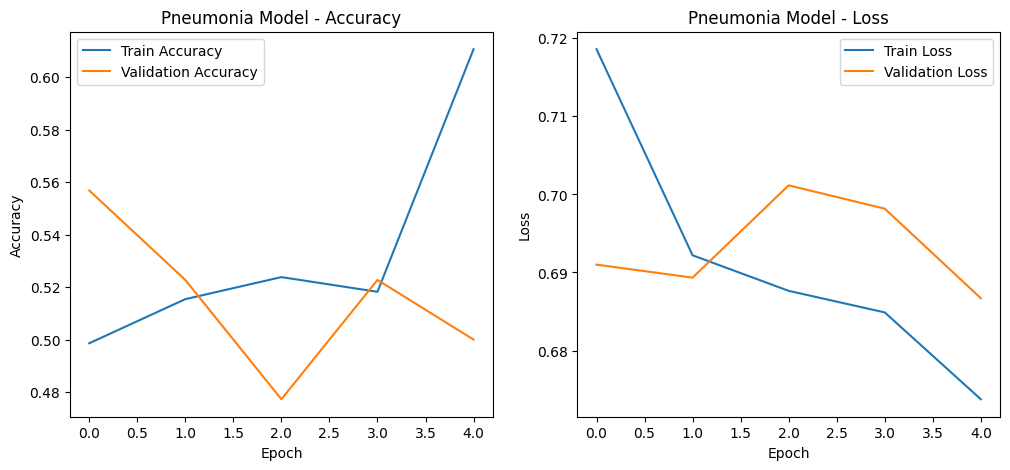

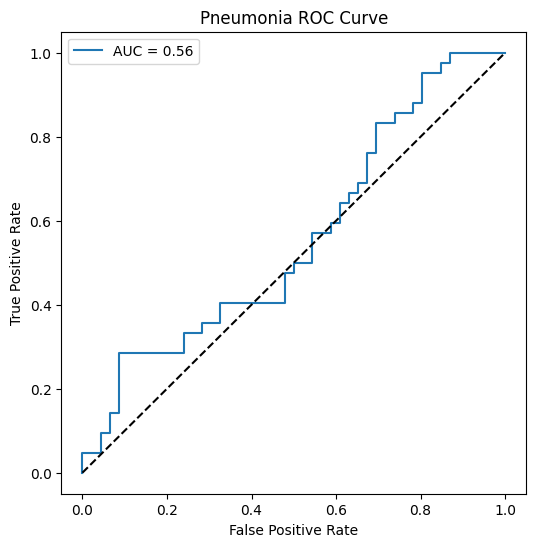


====== MEDICAL PREDICTION MENU ======
1. Skin Cancer Detection
2. Pneumonia Detection
3. Exit
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

⚠️ Prediction: Disease (malignant)
👋 Program Ended. Goodbye!


In [7]:
if __name__ == "__main__":
    main_menu()   
